In [9]:
import numpy as np
import os
import pandas as pd
import itertools
from PIL import Image
import seaborn as sns
import fitsio
import skimage.io
import galsim

from astrometry.util.fits import fits_table, merge_tables


# to make this notebook's output stable across runs
np.random.seed(7)

# To plot pretty figures
#%matplotlib inline
%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
REPO_DIR= os.path.join(os.environ['HOME'],
                       'myrepo/obiwan')
DATA_DIR= os.path.join(os.environ['HOME'],
                       'mydata')

# Galsim: demo[0-9].py

In [12]:
gal_flux = 1.e5    # total counts on the image
rhalf = 2.     # arcsec
psf_sigma = 1.     # arcsec
pixel_scale = 0.2  # arcsec / pixel
noise = 30. # standard 

gal = galsim.Sersic(1,flux=gal_flux, half_light_radius=rhalf)
gal = gal.shear(e1=0.3, e2=-0.8)
rot_gal= gal.rotate(np.pi/2.* galsim.radians)
psf = galsim.Gaussian(flux=1., sigma=psf_sigma) # PSF flux should always = 1
final = galsim.Convolve([gal, psf])
image = final.drawImage(scale=pixel_scale)
image.addNoise(galsim.GaussianNoise(sigma=noise))

<IPython.core.display.Javascript object>


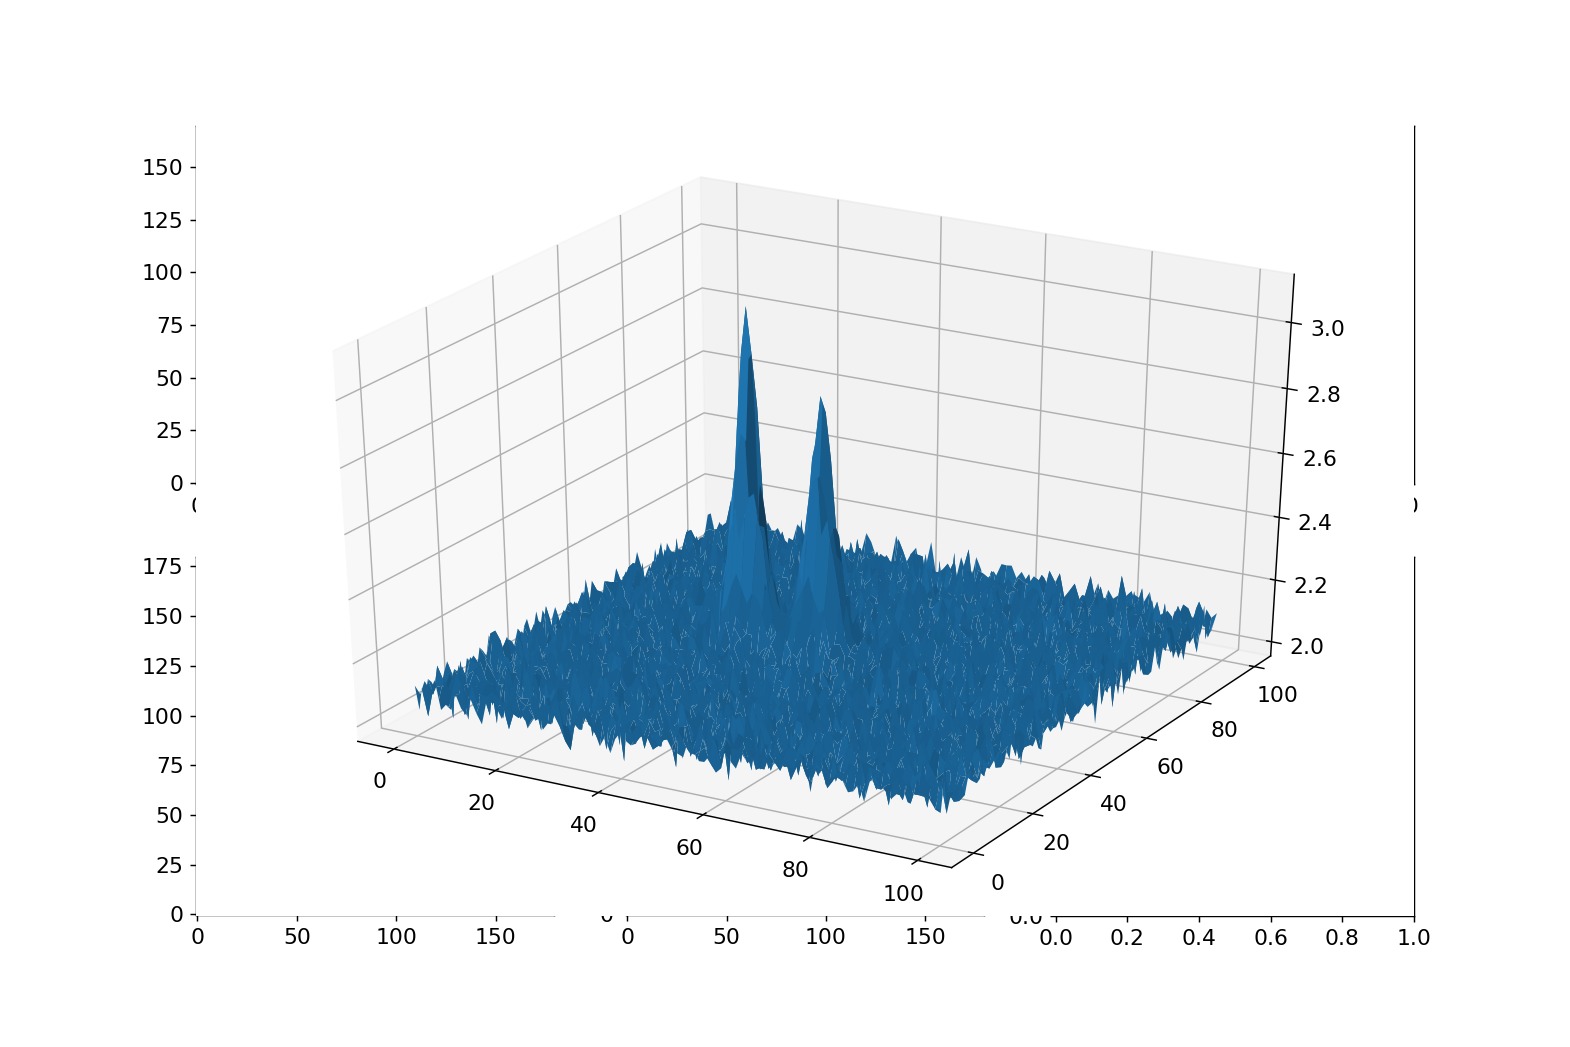

In [14]:
def readImage(fn,jpeg=False,ext=1):
    """Reads FITS and jpeg images so that x,y indices refer to the same pixels
    regardless of image format. x,y and fits correspond so the jpeg is rotated and flipped 
    to align with fits
    
    Args:
        fn: image filename
        jpeg: bool, is is a jpeg?
    """
    if jpeg:
        img= skimage.io.imread(fn)
        for i in range(3):
            img[:,:,i]= np.rot90(img[:,:,i].T,1)
    else:
        img= fitsio.FITS(fn)[ext].read()
    return img

def sliceImage(img,
               xslice=slice(None,None),yslice=slice(None,None)):
    """Not sure why, but simcat.x[xslice],simcat.y[yslice]
    corresponds to img[yslice,xslice], eg inverted for the image"""
    return img[yslice,xslice,...]

class plotImage(object):
    """Helper functions for displaying image and overlaying circles around sources
    
    Args:
        img: need to give as initial input b/c some helper funcs that dont directly
            use img, need its shape at least, see circles()
    """
    def imshow(self,img,ax,qs=[0.5,99.5]):
        if img.shape[-1] == 3:
            #minmax=np.percentile(np.sum(img,axis=2),q=qs)
            minmax=[None,None]
            cmap=None
        else:
            minmax=np.percentile(img,q=qs)
            cmap='gray'
        ax.imshow(img, interpolation='none', origin='lower',
                  cmap=cmap,vmin=minmax[0],vmax=minmax[1])
        ax.tick_params(direction='out')
        
    def circles(self,xs,ys,ax,
                img_shape=None,
                xslice=None,yslice=None,
                r_pixels=5./0.262,color='y'):
        """
        xs,ys: x,y positions of sources in pixels, e.g. tractor.bx or simcat.x
        img_shape: needed when xslice or yslice is None
        xlice,yslice: slice() objects into the image array
        r_pixels: radius circles in pixels
        """
        if (xslice is None) | (yslice is None):
            assert(not img_shape is None)
        if xslice is None:
            xslice= slice(0,img_shape[0])
        if yslice is None:
            yslice= slice(0,img_shape[1])
        keep= self.justInSlice(xs,ys,xslice,yslice)
        xpos,ypos= xs[keep]-xslice.start,ys[keep]-yslice.start
        
        from matplotlib.patches import Circle,Wedge
        from matplotlib.collections import PatchCollection
        dr= r_pixels/ 20 
        patches=[Wedge((x, y), r_pixels + dr, 0, 360,dr)
                 for x,y in zip(xpos, ypos) ]
        coll = PatchCollection(patches, color=color) #,alpha=1)
        ax.add_collection(coll)
        
    def justInSlice(self,x,y,xslice,yslice):
        """Returns bool array of x,y positions in the slice()"""
        return ((x >= xslice.start) & 
               (x <= xslice.stop) &
               (y >= yslice.start) & 
               (y <= yslice.stop))

fig,ax= plt.subplots(2,3,figsize=(12,8))
kw={'scale':pixel_scale}
plotImage().imshow(gal.drawImage(**kw).array,ax[0,0])
plotImage().imshow(rot_gal.drawImage(**kw).array,ax[0,1])
plotImage().imshow(psf.drawImage(**kw).array,ax[0,2])
plotImage().imshow(final.drawImage(**kw).array,ax[1,0])
plotImage().imshow(image.array,ax[1,1])

In [15]:
ba= np.random.rand(1000)
ba= ba[ba > 0.1]
beta= np.random.rand(len(ba))*180


<IPython.core.display.Javascript object>


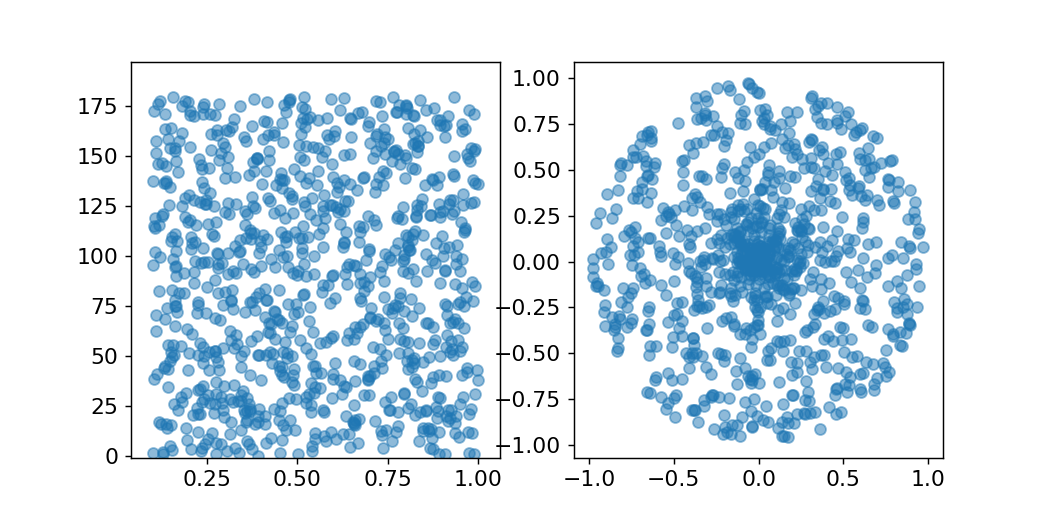

In [16]:
def ellip(q):
    """q: b/a ratio"""
    return (1-q**2)/(1+q**2)

def e1_e2(q,beta):
    """
    q: b/a ratio
    beta: rotation
    """
    e= ellip(q)
    return e*np.cos(2*beta), e*np.sin(2*beta)

fig,ax= plt.subplots(1,2,figsize=(8,4))
ax[0].scatter(ba,beta,alpha=0.5)
e1,e2= e1_e2(ba,beta)
ax[1].scatter(e1,e2,alpha=0.5)

### Can galsim draw all these orientations?

In [11]:
for one,two in zip(e1,e2):
    gal.shear(e1=one, e2=two)

# DECam CCD + PSFex psf

In [17]:
from legacypipe.decam import DecamImage
from legacypipe.survey import LegacySurveyData

In [18]:
ccds= fits_table(os.path.join(DATA_DIR,
                             '1741p242/dr5/legacysurvey-1741p242-ccds.fits'))
t= ccds[((pd.Series(ccds.image_filename).str.contains('c4d_160116_084245_oki_z_v1.fits')) &
         (ccds.ccdname == 'S17'))]
#for col in ['image_filename','ccdname','filter','camera']:
#    t.set(col,t.get(col)[0])
#t

In [19]:
# Generator class for LegacySurveyImage() objects
survey = LegacySurveyData(ccds=ccds)
#survey= DecamImage(ccds=)
for ccd in t:
    # a LegacySurveyImage
    im = survey.get_image_object(ccd)
#X = im.get_good_image_subregion()
kwargs = dict(pixPsf=True, splinesky=True, subsky=False, hybridPsf=True,
              pixels=True, dq=True, invvar=True)
tim = im.get_tractor_image(**kwargs)



On NERSC, you can do:
  module use /project/projectdirs/cosmo/work/decam/versions/modules
  module load legacysurvey

Now using the current directory as LEGACY_SURVEY_DIR, but this is likely to fail.

Reading image slice: None
Reading image from /home/kaylan/myrepo/obiwan/doc/nb/images/decam/DECam_CP/CP20160107/c4d_160116_084245_oki_z_v1.fits.fz hdu 15
Reading inverse-variance from /home/kaylan/myrepo/obiwan/doc/nb/images/decam/DECam_CP/CP20160107/c4d_160116_084245_oow_z_v1.fits.fz hdu 15
Reading data quality from /home/kaylan/myrepo/obiwan/doc/nb/images/decam/DECam_CP/CP20160107/c4d_160116_084245_ood_z_v1.fits.fz hdu 15
Reading merged spline sky models from /home/kaylan/myrepo/obiwan/doc/nb/calib/decam/splinesky-merged/00511/decam-00511967.fits
Found 1 matching CCD
Reading merged PsfEx models from /home/kaylan/myrepo/obiwan/doc/nb/calib/decam/psfex-merged/00511/decam-00511967.fits
Found 1 matching CCD
Using PSF model HybridPixelizedPSF: Gaussian sigma 1.73, Pix PixelizedPsfEx
-- creat

In [20]:
tim.getImage().max(),tim.invvar.shape,tim.data.shape,tim.dq.shape

(77.765678, (4094, 2046), (4094, 2046), (4094, 2046))

In [21]:
psf = tim.psf
wcs = tim.wcs.wcs
sky = tim.sky

## How draw a 22 mag galaxy in a tim image which has NanoMaggie units?

In [22]:
def magToNanomaggies(mag):
    nmgy = 10. ** ((mag - 22.5) / -2.5)                                        
    return nmgy

def global_wcs(tim):
    from astropy.io import fits
    #self.wcs = tim.getWcs()
    #self.psf = tim.getPsf()
    # Tractor wcs object -> galsim wcs object
    temp_hdr = fitsio.FITSHDR()
    subwcs = tim.wcs.wcs.get_subimage(tim.wcs.x0, tim.wcs.y0,
                              int(tim.wcs.wcs.get_width())-tim.wcs.x0,
                              int(tim.wcs.wcs.get_height())-tim.wcs.y0)
    subwcs.add_to_header(temp_hdr)
    # Galsim uses astropy header, not fitsio
    hdr = fits.Header()
    for key in temp_hdr.keys(): 
        hdr[key]=temp_hdr[key]
    return galsim.GSFitsWCS(header=hdr)

def local_wcs(global_wcs,x,y):
    return global_wcs.local(image_pos= galsim.PositionD(x,y))

def galsim_psf(x,y,tim,global_wcs):
    psf_tim= tim.psf.getPointSourcePatch(x,y)
    return galsim.InterpolatedImage(galsim.Image(psf_tim.getImage()), 
                                    wcs= global_wcs)

def galsim_galaxy(x,y,tim,global_wcs,
                  n=1,rhalf=2.,mag=22.,
                  e1=0.3,e2=-0.8,angle=np.pi/2):
    psf= galsim_psf(x,y,tim,global_wcs)
    gal = galsim.Sersic(n,flux=magToNanomaggies(mag), half_light_radius=rhalf)
    gal= gal.shear(e1=e1, e2=e2)
    gal= gal.rotate(angle* galsim.radians)
    return galsim.Convolve([gal, psf])

def Draw(obj,x,y,global_wcs):
    """obj: galsim object having method drawImage()"""
    image= obj.drawImage(wcs=local_wcs(global_wcs,x,y), method='no_pixel')
    # assign to a location
    image.setCenter(x,y)
    return image
    


wcs= global_wcs(tim)
    
xpos,ypos,hw= 1000,1000,30
xslc=slice(xpos-hw,xpos+hw)
yslc=slice(ypos-hw,ypos+hw)

psf= galsim_psf(xpos,ypos,tim,wcs)
psf= Draw(psf,xpos,ypos,wcs)

gal= galsim_galaxy(xpos,ypos,tim,wcs,
                   n=1,rhalf=1.,mag=20.,
                   e1=0.3,e2=-0.8,angle=np.pi/2)
gal= Draw(gal,xpos,ypos,wcs)

tim_galsim = galsim.Image(tim.getImage())

overlap= {'gal':tim_galsim.bounds & gal.bounds,
          'psf':tim_galsim.bounds & psf.bounds}
psf.bounds,overlap['psf'],gal.bounds,overlap['gal']

(galsim.BoundsI(xmin=978, xmax=1021, ymin=978, ymax=1021),
 galsim.BoundsI(xmin=978, xmax=1021, ymin=978, ymax=1021),
 galsim.BoundsI(xmin=961, xmax=1038, ymin=961, ymax=1038),
 galsim.BoundsI(xmin=961, xmax=1038, ymin=961, ymax=1038))

<IPython.core.display.Javascript object>


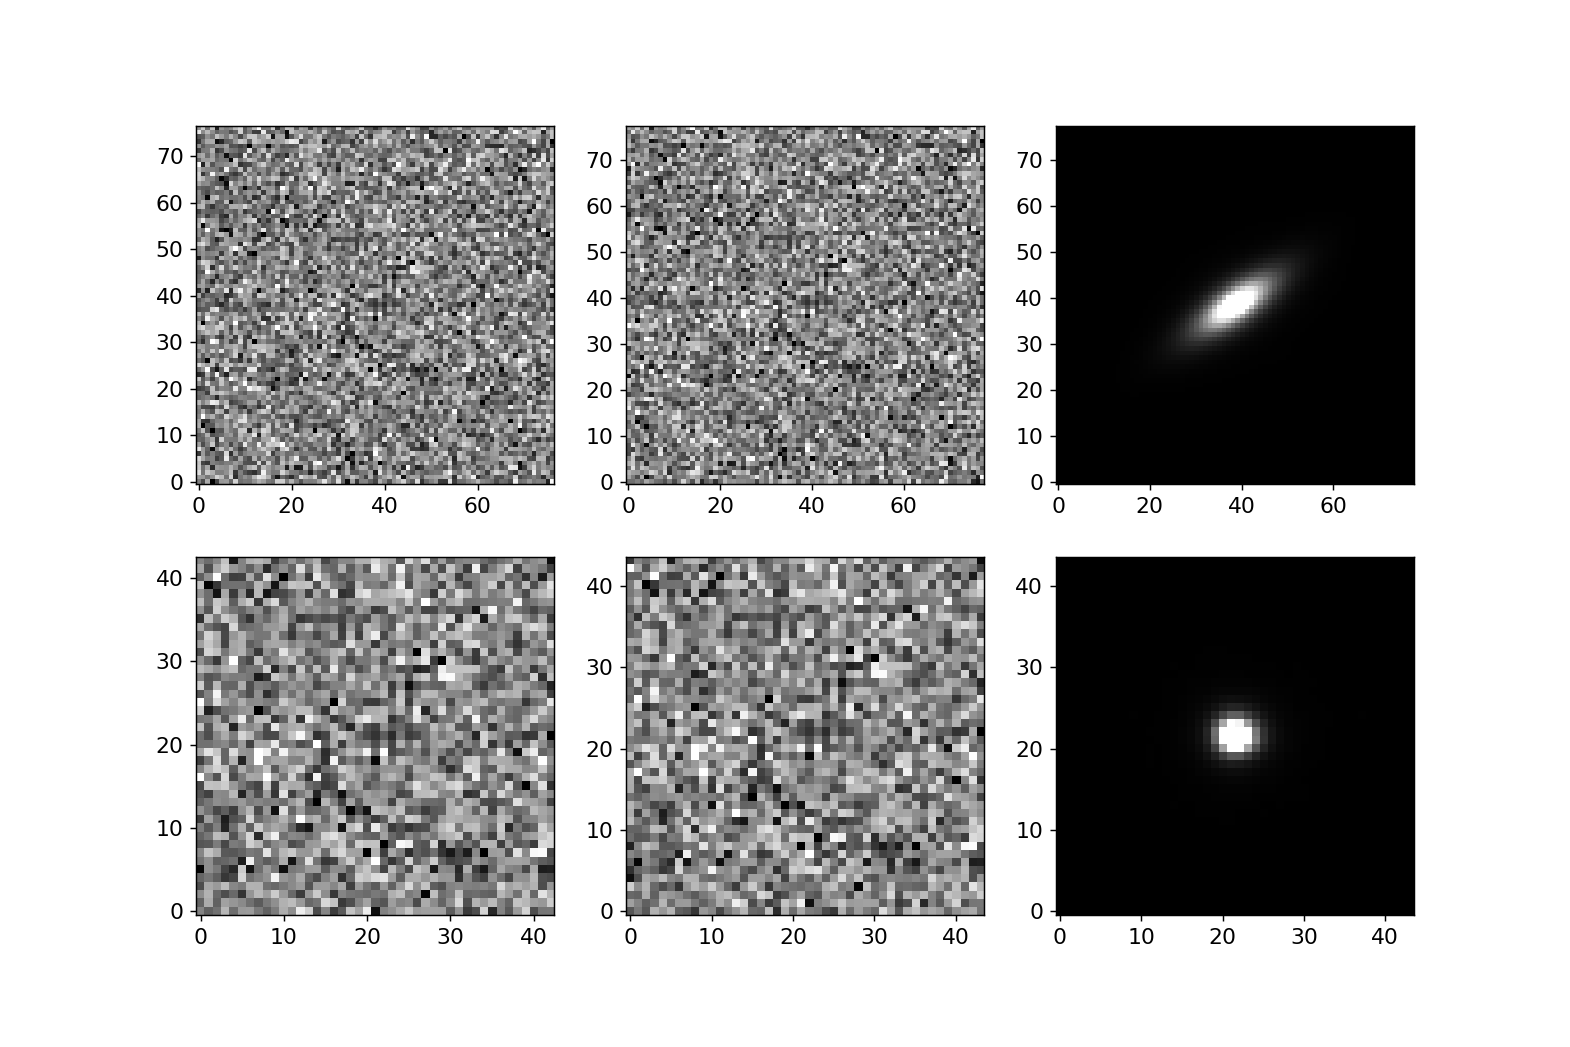

In [23]:
hdu=fitsio.FITS('images/decam/DECam_CP/CP20160107/c4d_160116_084245_oki_z_v1.fits.fz')
cp=hdu['S17'].read()

fig,ax= plt.subplots(2,3,figsize=(12,8))
##
olap= overlap['gal']
plotImage().imshow(sliceImage(cp,xslice=slice(olap.xmin,olap.xmax),
                              yslice=slice(olap.ymin,olap.ymax)),
                   ax[0,0])
plotImage().imshow(tim_galsim[olap].array,ax[0,1])
plotImage().imshow(gal[olap].array,ax[0,2])
##
olap= overlap['psf']
plotImage().imshow(sliceImage(cp,xslice=slice(olap.xmin,olap.xmax),
                              yslice=slice(olap.ymin,olap.ymax)),
                   ax[1,0])
plotImage().imshow(tim_galsim[olap].array,ax[1,1])
plotImage().imshow(psf[olap].array,ax[1,2])

## Add galaxy to image and add noisy galaxy to image

In [24]:
def addNoise(image,zpscale=None,gain=4.,seed=7):
    """image: source after it has undergone drawImage()"""
    nano2e= zpscale * gain 
    src_e= image.copy() * nano2e 
    var_e= (image.copy() * nano2e)**2
    rng = galsim.BaseDeviate(7)
    src_e.addNoise(galsim.VariableGaussianNoise(rng,var_e))
    src_cnts= src_e / nano2e
    var_cnts= var_e / nano2e**2
    return src_cnts,var_cnts

<IPython.core.display.Javascript object>


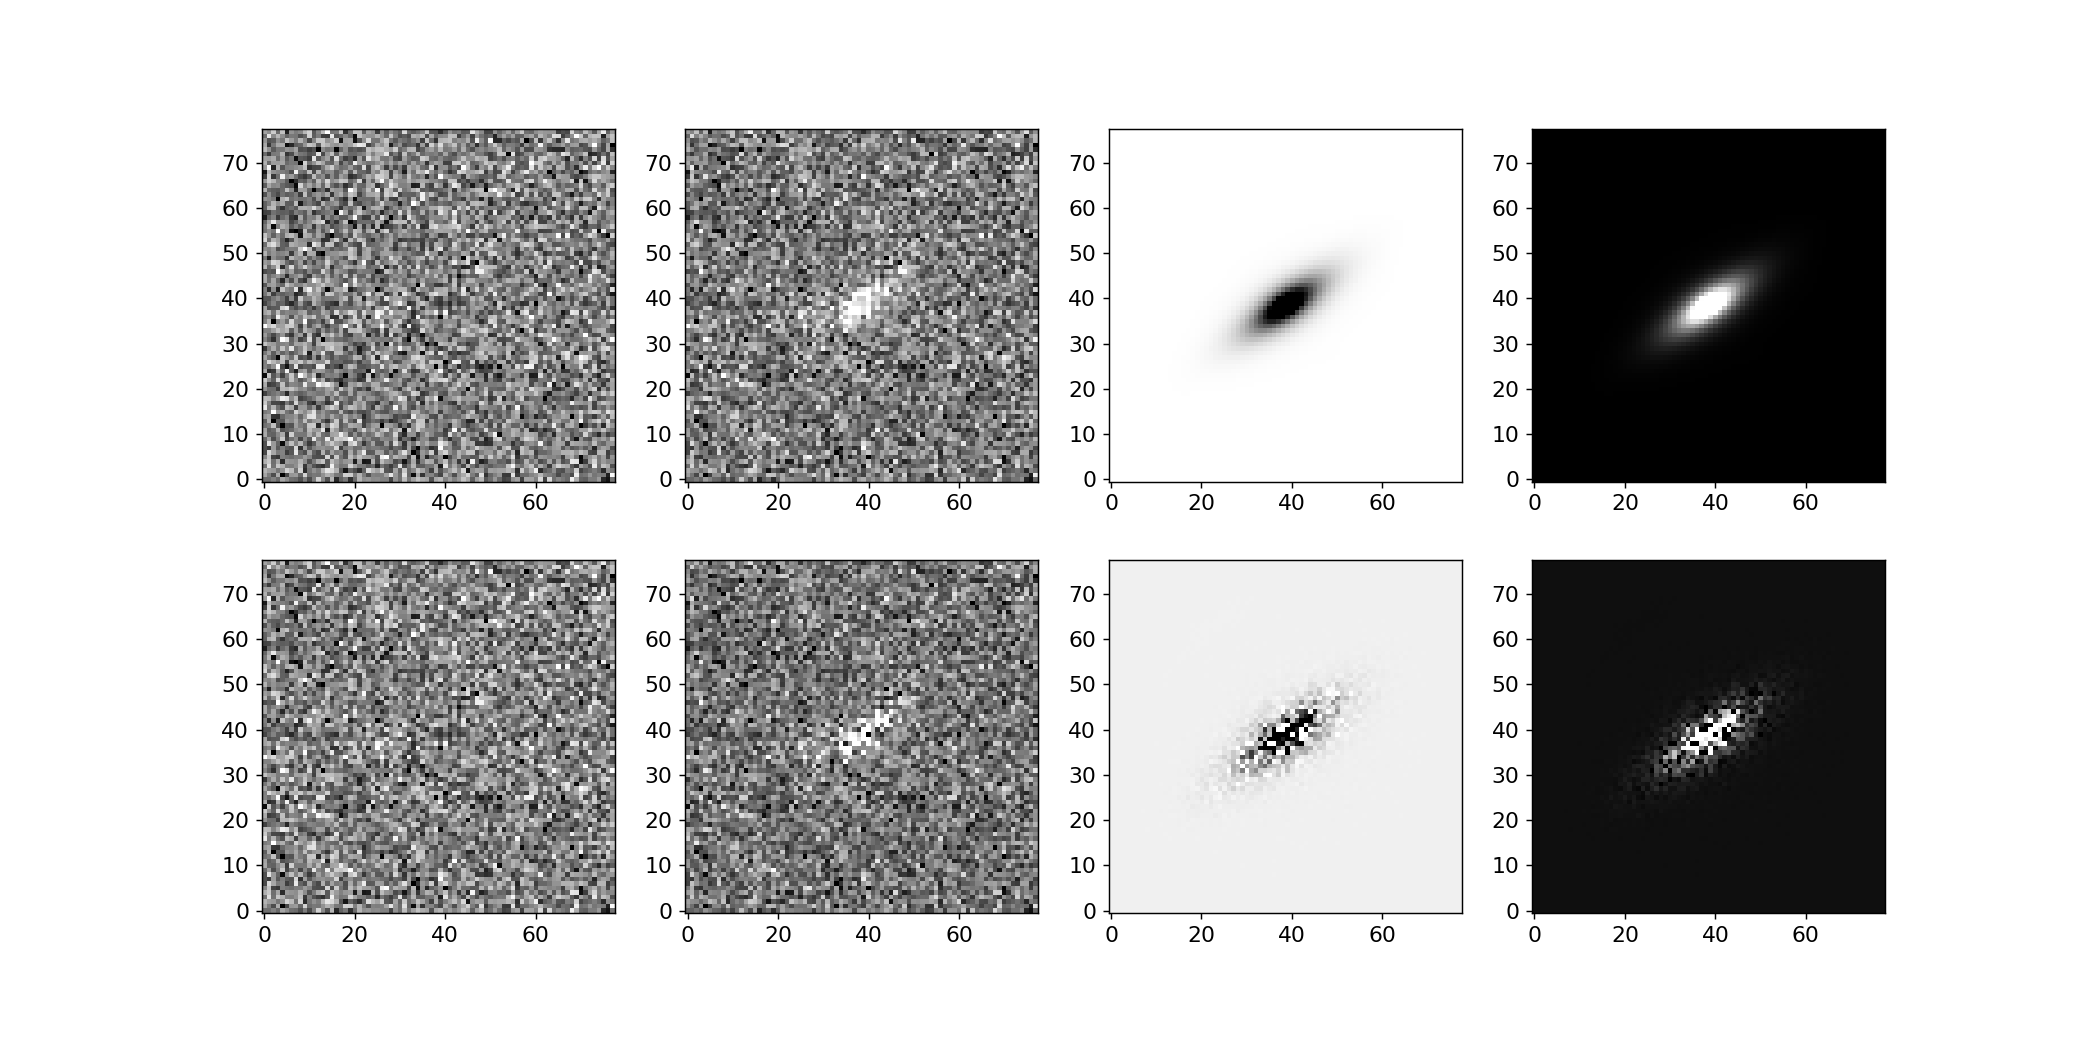

In [25]:
olap= overlap['gal']
tim_wgal= tim_galsim.copy()
tim_wgal[olap] += gal[olap]

gal_wnoise, gal_wnoise_var= addNoise(gal,zpscale=tim.zpscale, gain=1.)
tim_wgalnoise= tim_galsim.copy()
tim_wgalnoise[olap] += gal_wnoise[olap]

fig,ax= plt.subplots(2,4,figsize=(16,8))
plotImage().imshow(tim_galsim[olap].array,ax[0,0])
plotImage().imshow(tim_wgal[olap].array,ax[0,1])
plotImage().imshow(tim_galsim[olap].array - tim_wgal[olap].array,ax[0,2])
plotImage().imshow(gal[olap].array,ax[0,3])
##
plotImage().imshow(tim_galsim[olap].array,ax[1,0])
plotImage().imshow(tim_wgalnoise[olap].array,ax[1,1])
plotImage().imshow(tim_galsim[olap].array - tim_wgalnoise[olap].array,ax[1,2])
plotImage().imshow(gal_wnoise[olap].array,ax[1,3])

<IPython.core.display.Javascript object>


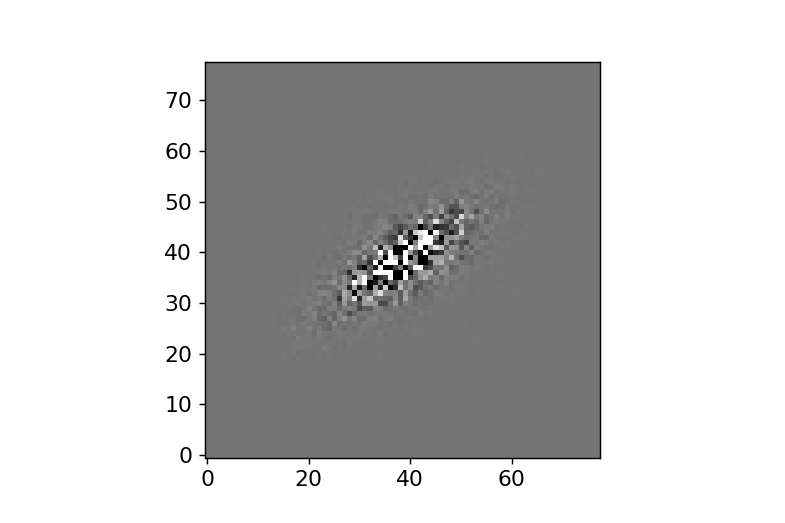

In [26]:
fig,ax= plt.subplots()
noise_only= gal_wnoise[olap].array - gal[olap].array
plotImage().imshow(noise_only,ax)


/home/kaylan/env_galsim/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


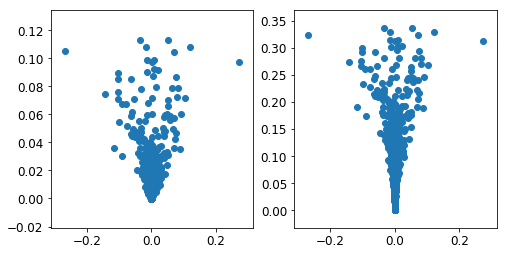

In [23]:
fig,ax= plt.subplots(1,2,figsize=(8,4))
ax[0].scatter(noise_only,gal[olap].array.flatten())
ax[1].scatter(noise_only,np.sqrt(gal[olap].array.flatten()))

## When I look at a single band Tractor source of some mag, and then I inject the same thing, does my simulated source look similar? Does it change when the noise model changes?

In [31]:
dr5tractor= fits_table(os.path.join(DATA_DIR,
                 '1741p242','dr5',
                 'tractor-1741p242.fits'))

img_jpg= readImage(os.path.join(DATA_DIR,
                   '1741p242','dr5',
                   'legacysurvey-1741p242-image.jpg'),
                    jpeg=True)

ccds= fits_table(os.path.join(DATA_DIR,
                 '1741p242','dr5',
                 'ccds-annotated-dr5-near-1741p242.fits'))
                  # 'legacysurvey-1741p242-ccds.fits'))

In [32]:
oneBand= (dr5tractor.nobs_g + dr5tractor.nobs_r + dr5tractor.nobs_z) == 1
isGal= dr5tractor.get('type') != 'PSF '
dr5tractor.cut(((oneBand) &
                (isGal)))
len(dr5tractor)

6

<IPython.core.display.Javascript object>


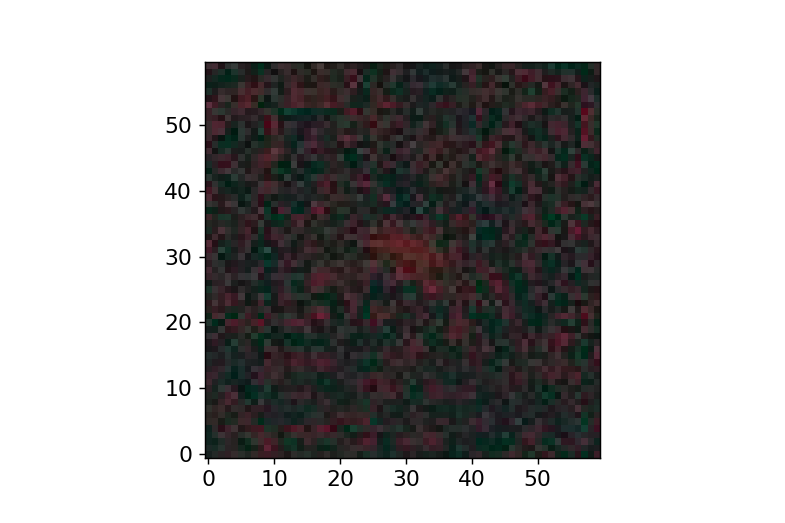

(3477, 937, 0.0, 0.0, 3.0918508)


<IPython.core.display.Javascript object>


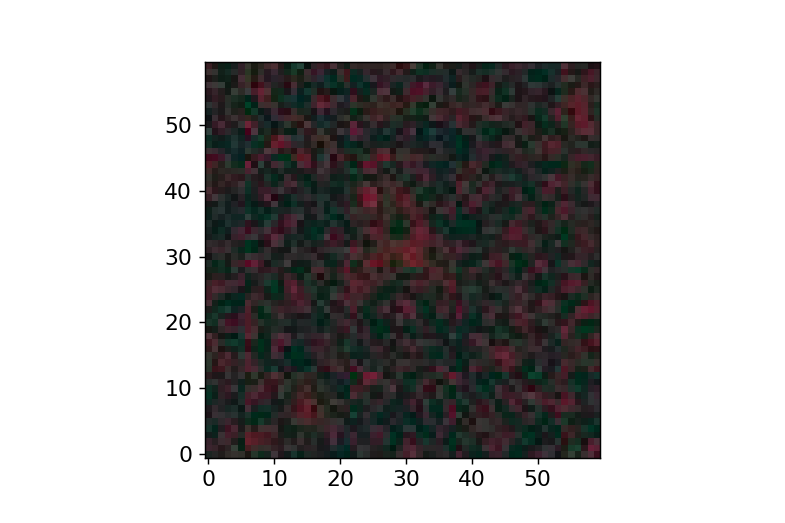

(3416, 1073, 0.0, 0.0, 2.3392417)


<IPython.core.display.Javascript object>


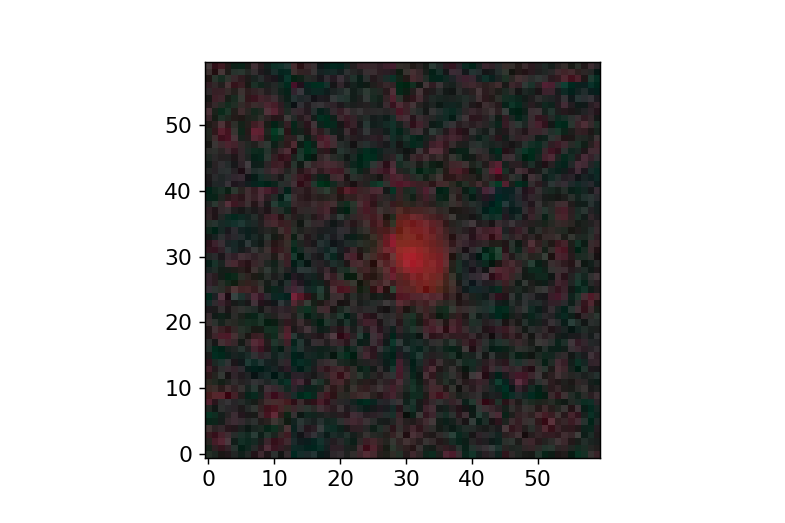

(3409, 1701, 0.0, 0.0, 13.610537)


<IPython.core.display.Javascript object>


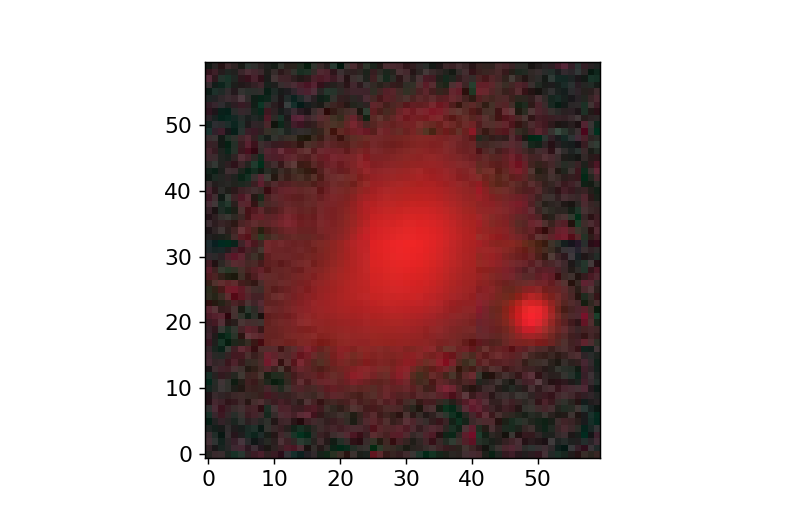

(3493, 1725, 0.0, 0.0, 377.83987)


<IPython.core.display.Javascript object>


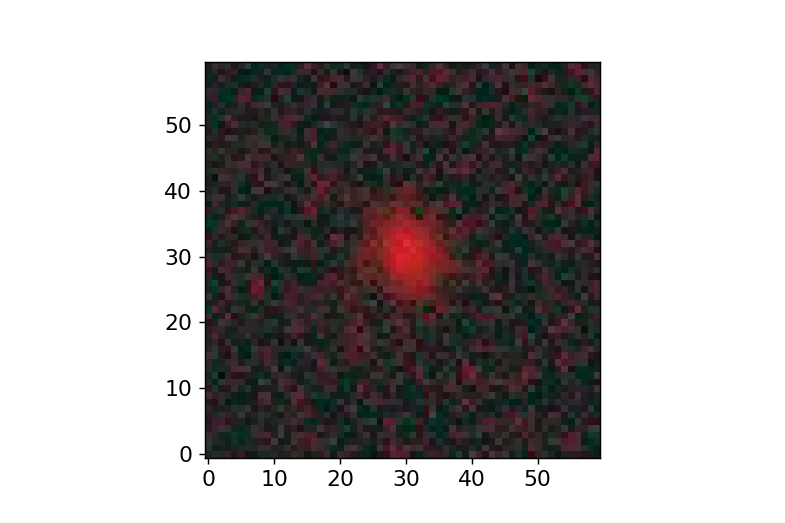

(189, 2872, 0.0, 0.0, 38.265545)


<IPython.core.display.Javascript object>


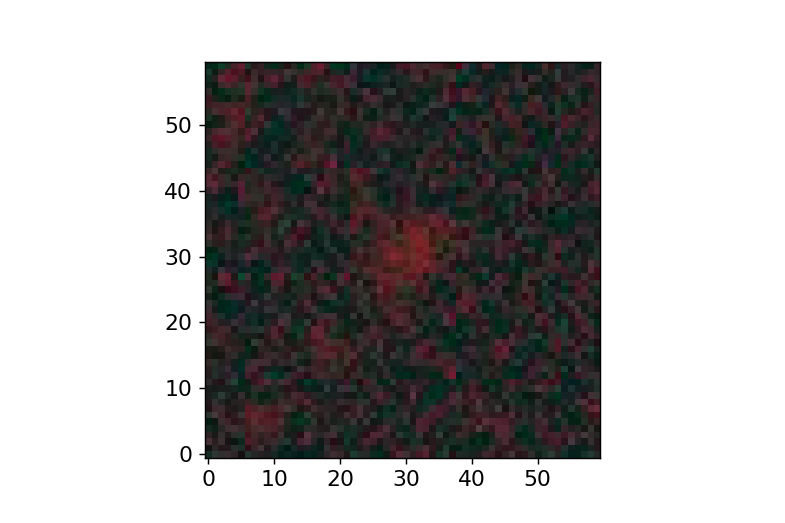

(3416, 3234, 0.0, 0.0, 6.7380943)


In [33]:
hw=30
for trac in dr5tractor:
    fig,ax=plt.subplots()
    x,y= int(trac.bx),int(trac.by)
    print(x,y,trac.flux_g,trac.flux_r,trac.flux_z)
    plotImage().imshow(sliceImage(img_jpg,xslice=slice(x-hw,x+hw),yslice=slice(y-hw,y+hw)),
                       ax)

<IPython.core.display.Javascript object>


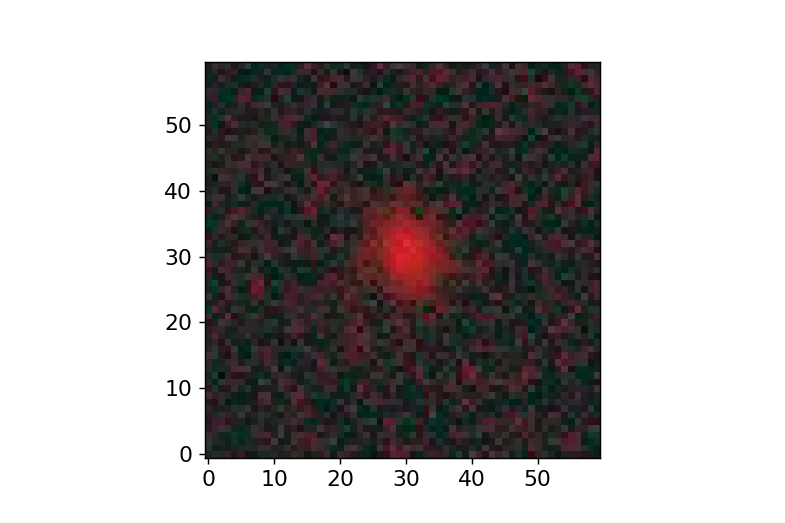

In [34]:
trac= dr5tractor[-2]
fig,ax=plt.subplots()
x,y= int(trac.bx),int(trac.by)
plotImage().imshow(sliceImage(img_jpg,xslice=slice(x-hw,x+hw),yslice=slice(y-hw,y+hw)),
                   ax)

In [35]:
def flux2mag(flux):
    return -2.5*np.log10(1e-9 * flux)
    
print(flux2mag(trac.flux_z), trac.mw_transmission_z, trac.ra,trac.dec)
print(trac.type, trac.shapedev_r, trac.shapedev_e1, trac.shapedev_e2)

(18.542980245126476, 0.97755975, 174.247150296912, 24.328052713899101)
('DEV ', 0.3695592, 0.33375761, 0.27342117)


In [36]:
# Which ccd is this source in?
ra,dec= trac.ra,trac.dec
ramax= np.max([ccds.ra1,ccds.ra2],axis=0) 
ramin= np.min([ccds.ra0,ccds.ra3],axis=0)
decmax= np.max([ccds.dec1,ccds.dec0],axis=0)
decmin= np.min([ccds.dec3,ccds.dec3],axis=0)

ccds.cut((ra > ramin) & 
         (ra < ramax) & 
         (dec > decmin) & 
         (dec < decmax))
len(ccds),ccds.image_filename[0],ccds.ccdname[0]

(1,
 'decam/DECam_CP/CP20150326/c4d_150329_031648_ooi_z_v1.fits.fz     ',
 'S16 ')

In [37]:
ccds= fits_table(os.path.join(DATA_DIR,
                             '1741p242/dr5/legacysurvey-1741p242-ccds.fits'))
t= ccds[((pd.Series(ccds.image_filename).str.contains('c4d_150329_031648_ooi_z_v1.fits.fz')) &
         (ccds.ccdname == 'S16'))]
survey = LegacySurveyData(ccds=ccds)
#survey= DecamImage(ccds=)
for ccd in t:
    # a LegacySurveyImage
    im = survey.get_image_object(ccd)
#X = im.get_good_image_subregion()
kwargs = dict(pixPsf=True, splinesky=True, subsky=False, hybridPsf=True,
              pixels=True, dq=True, invvar=True)
tim = im.get_tractor_image(**kwargs)

On NERSC, you can do:
  module use /project/projectdirs/cosmo/work/decam/versions/modules
  module load legacysurvey

Now using the current directory as LEGACY_SURVEY_DIR, but this is likely to fail.

Reading image slice: None
Reading image from /home/kaylan/myrepo/obiwan/doc/nb/images/decam/DECam_CP/CP20150326/c4d_150329_031648_ooi_z_v1.fits.fz hdu 14
Reading inverse-variance from /home/kaylan/myrepo/obiwan/doc/nb/images/decam/DECam_CP/CP20150326/c4d_150329_031648_oow_z_v1.fits.fz hdu 14
Reading data quality from /home/kaylan/myrepo/obiwan/doc/nb/images/decam/DECam_CP/CP20150326/c4d_150329_031648_ood_z_v1.fits.fz hdu 14
Reading merged spline sky models from /home/kaylan/myrepo/obiwan/doc/nb/calib/decam/splinesky-merged/00425/decam-00425662.fits
Found 1 matching CCD
Reading merged PsfEx models from /home/kaylan/myrepo/obiwan/doc/nb/calib/decam/psfex-merged/00425/decam-00425662.fits
Found 1 matching CCD
Using PSF model HybridPixelizedPSF: Gaussian sigma 2.29, Pix PixelizedPsfEx
-- creat

In [38]:
tim.wcs.wcs.radec2pixelxy(trac.ra,trac.dec), tim.getImage().shape

((True, 1040.2343125758416, 3722.5915990517656), (4094, 2046))

In [39]:
print(flux2mag(trac.flux_z), trac.mw_transmission_z, trac.ra,trac.dec)
print(trac.type, trac.shapedev_r, trac.shapedev_e1, trac.shapedev_e2)

(18.542980245126476, 0.97755975, 174.247150296912, 24.328052713899101)
('DEV ', 0.3695592, 0.33375761, 0.27342117)


In [81]:
wcs= global_wcs(tim)
    
xpos,ypos,hw= 1040,3723,30

psf= galsim_psf(xpos,ypos,tim,wcs)
psf= Draw(psf,xpos,ypos,wcs)

gal= galsim_galaxy(xpos,ypos,tim,wcs,
                   n=4,rhalf=0.3696,mag=18.543,
                   e1=0.334,e2=0.273,angle=0)
gal= Draw(gal,xpos,ypos,wcs)
gal_wnoise,_= addNoise(gal,zpscale=tim.zpscale, gain=4.)
# Move fake galaxy over 15 pixels so not on top of real one
gal.setCenter(xpos+15,ypos)
gal_wnoise.setCenter(xpos+15,ypos)

tim_galsim = galsim.Image(tim.getImage())

olap= tim_galsim.bounds & gal.bounds
psf.bounds,gal.bounds,olap

(galsim.BoundsI(xmin=1019, xmax=1060, ymin=3702, ymax=3743),
 galsim.BoundsI(xmin=1005, xmax=1104, ymin=3673, ymax=3772),
 galsim.BoundsI(xmin=1005, xmax=1104, ymin=3673, ymax=3772))

<IPython.core.display.Javascript object>


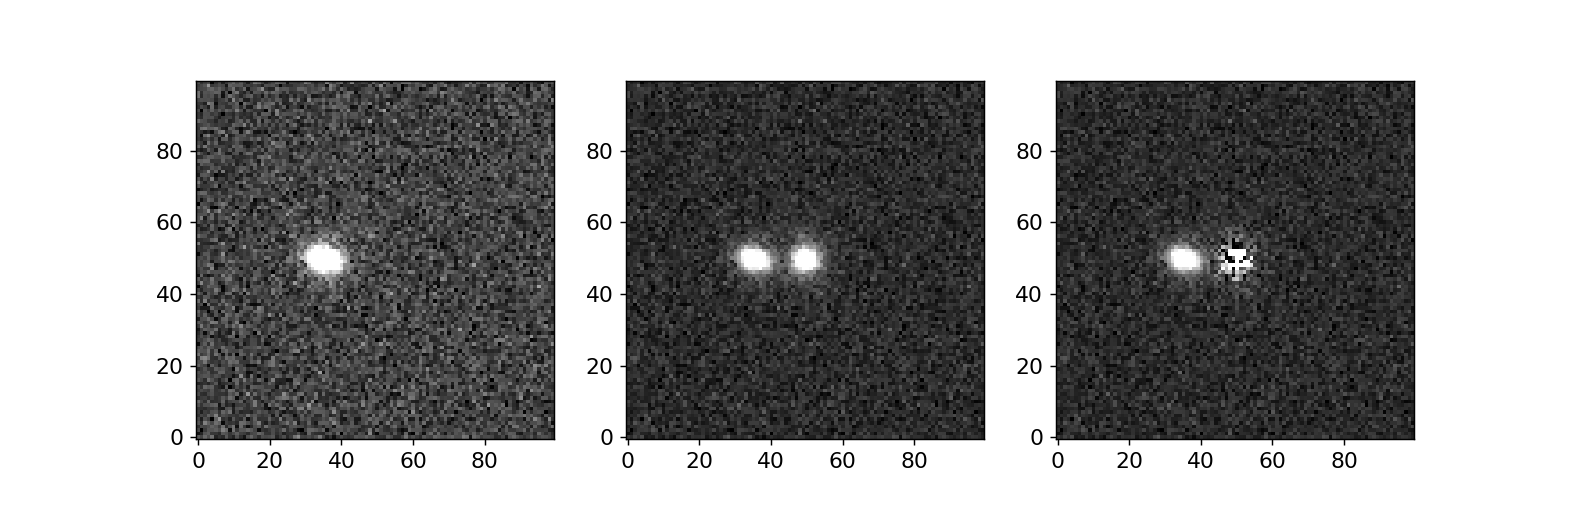

In [84]:
tim_wgal= tim_galsim.copy()
tim_wgal[olap] += gal[olap]
tim_wgal_wnoise= tim_galsim.copy()
tim_wgal_wnoise[olap] += gal_wnoise[olap]

fig,ax= plt.subplots(1,3,figsize=(12,4))
plotImage().imshow(tim_galsim[olap].array,ax[0])
plotImage().imshow(tim_wgal[olap].array,ax[1])
plotImage().imshow(tim_wgal_wnoise[olap].array,ax[2])

## Noisy source looks completely wrong, why? Lets put this in 3D

In [ ]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [85]:
def plot3d(image):
    data = [
        go.Surface(
            z=image
        )
    ]
    fig = go.Figure(data=data)
    iplot(fig, filename='image')
    
plot3d(tim_wgal[olap].array)

In [87]:
plot3d(tim_wgal_wnoise[olap].array)

# How much flux to I add compare to what's in the real source?

<IPython.core.display.Javascript object>


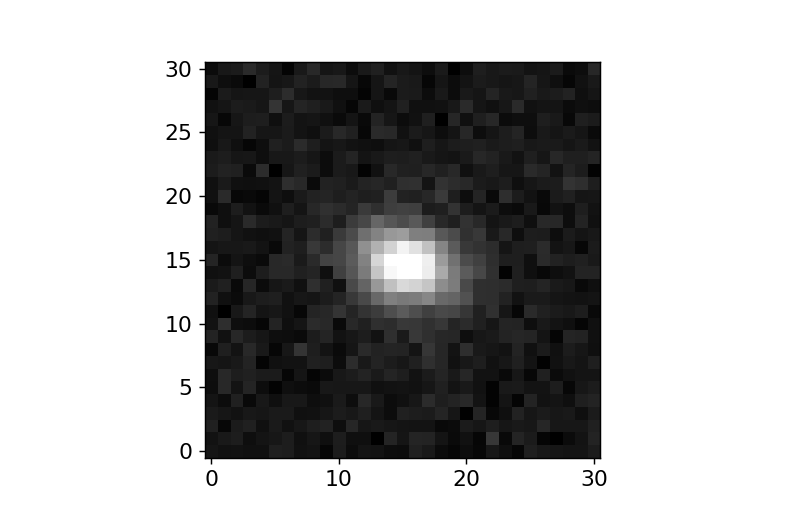

In [66]:
fig,ax=plt.subplots()
hw=15
box= galsim.BoundsI(xmin=xpos-hw,xmax=xpos+hw,ymin=ypos-hw,ymax=ypos+hw)
plotImage().imshow(tim_galsim[box].array,ax)

In [68]:
plot3d(tim_galsim[box].array)

## Why is total counts in "tim" image NOT even close to tractor catalgoue flux??

In [78]:
tim_galsim[box].array.shape,tim_galsim[box].array.sum(), trac.flux_z, gal.added_flux, tim.zpscale

((31, 31), 2047.7993, 38.265545, 39.064910591005074, 514.01637944604954)

## tim.getImage() is in units of "NanoMaggies", while CP CCD is units of CP. Can I predict what these should be?

In [135]:
hdu=fitsio.FITS('images/decam/DECam_CP/CP20160107/c4d_160116_084245_oki_z_v1.fits.fz')
cp=hdu['S17'].read()
cp.max(), tim.getImage().max()

(51861.047, 77.765678)

In [108]:
hdu=fitsio.FITS('images/decam/DECam_CP/CP20160107/c4d_160116_084245_oow_z_v1.fits.fz')
cp_ivar=hdu['S17'].read()

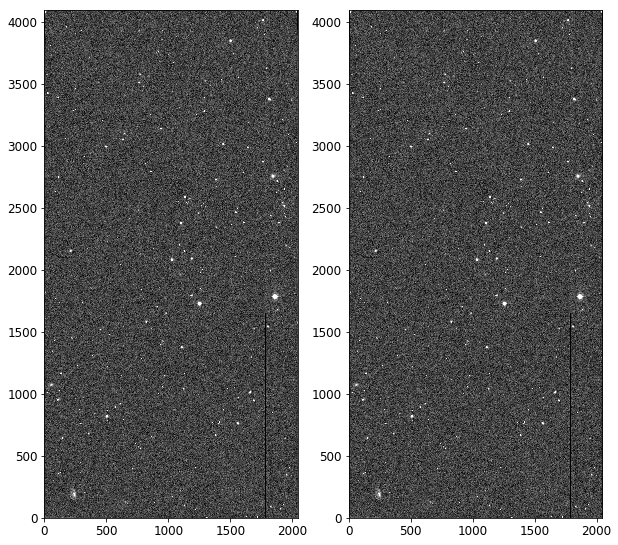

In [109]:
fig,ax= plt.subplots(1,2,figsize=(10,10))
plotImage().imshow(tim.getImage(),ax[0])
plotImage().imshow(cp,ax[1])
#psfim = self.psf.getPointSourcePatch(self.xpos, self.ypos).getImage()

## ratio of CP image to tim Image should be zpscale

In [110]:
slc= slice(1000,1500)
img_ratio= (cp/tim.getImage())[slc,slc].flatten()
ivar_ratio= (tim.getInvvar()/cp_ivar)[slc,slc].flatten()
set(img_ratio),set(ivar_ratio)

/home/kaylan/env_galsim/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until


({666.88855, 666.88861, 666.88867},
 {-0.0,
  444740.31,
  444740.34,
  444740.38,
  444740.41,
  444740.44,
  444740.47,
  444740.5})

In [111]:
tim.zpscale

666.88859076847427

In [118]:
zp= t.ccdzpt + 2.5 * np.log10(t.exptime)
zpscale= 10**(zp - 22.5)/2.5
zpscale

array([ 4594021.], dtype=float32)

In [115]:
t.zpt

array([ 24.81708145], dtype=float32)

In [88]:

img_ratio= f
ivar_ratio= f**2
print(img_ratio,ivar_ratio)

(array([ 4594021.], dtype=float32), array([  2.11050289e+13], dtype=float32))


## How does the PSF vary across the CCD image?

In [78]:
t.ccdzpt, t.ccdzpt + 2.5 * np.log10(t.exptime)

(array([ 24.80240822], dtype=float32), array([ 29.56013298], dtype=float32))

In [79]:
im.ccdzpt

29.560133218765259